In [1]:
# 导入库
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from   datetime import datetime, timedelta
from   pandas.tseries.offsets import *


In [2]:
# 导入情感数据
df_Reuters_sentiment = pd.read_csv('../Data/Merged Sentiment Reuters.csv')
df_MW_sentiment = pd.read_csv('../Data/Merged Sentiment MW.csv')

# 拼接两个网站的情感分数
df_sentiment = [df_MW_sentiment, df_Reuters_sentiment]
# df_sentiment = [df_MW_sentiment]
# df_sentiment = [df_Reuters_sentiment]
df_sentiment = pd.concat(df_sentiment)
df_sentiment = df_sentiment.groupby(['Date', 'Country']).mean(numeric_only=True).reset_index()

# 修改列名
df_sentiment = df_sentiment.rename(columns={
    'LMD_Polarity': 'LMD',
    'HIV4_Polarity': 'HIV4',
    'Vader_Polarity': 'Vader',
    'FinBert_Polarity': 'FinBert'
})

# 展示数据
df_sentiment.head()

,Date,Country,Unnamed: 0,LMD,HIV4,Vader,FinBert
0,2012-01-01,Australia,0.0,NaN,NaN,NaN,NaN
1,2012-01-01,Canada,4108.5,NaN,NaN,NaN,NaN
2,2012-01-01,China,8217.0,-0.730048,0.292335,-0.59944,-0.560693
3,2012-01-01,Denmark,12325.5,NaN,NaN,NaN,NaN
4,2012-01-01,Finland,16434.0,NaN,NaN,NaN,NaN


In [3]:
# 导入收益率数据
df_return = pd.read_csv('../Data/daily_return.csv')

# 展示数据
df_return.head()

# # 展示为0或者NA的数据的数量
# print('Number of 0 or NA in each column:')
# print(df_return.isin([0, np.nan]).sum())


,Date,New Zealand,United Kingdom,Finland,Norway,United States,Sweden,Korea,Japan,Canada,...,Australia,Germany,France,China,Switzerland,Spain,Denmark,Italy,Singapore,Portugal
0,2011-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-12-02,-0.010866,-0.207038,0.302897,0.235483,0.489692,0.154354,0.094609,-0.042270,0.178307,...,0.053087,0.393824,-1.345329,0.328191,0.241278,0.536400,0.065521,-0.189497,-0.251753,0.148492
2,2011-12-05,0.077141,-0.460678,-0.474224,-0.158909,-0.084015,-0.179613,0.056292,0.165816,0.227525,...,0.302855,-0.615728,1.099039,0.264403,-0.125720,3.778843,-1.723893,5.259712,-0.012405,3.308727
3,2011-12-06,0.201784,0.810078,0.100602,-0.190226,-0.406179,0.198203,-0.004941,0.066255,-0.330724,...,0.354603,0.150150,-0.863361,-0.157734,0.335027,-0.630513,0.272330,0.715348,0.047384,1.062182
4,2011-12-07,0.187048,0.129148,0.496636,0.290407,0.543003,0.567308,-0.043160,0.002849,0.596567,...,-0.273399,0.762903,0.199724,0.001528,0.198283,-1.476326,-0.028845,-0.948723,-0.251362,1.737582


In [4]:
# 转换日期格式
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], format='%Y-%m-%d')
df_return['Date'] = pd.to_datetime(df_return['Date'], format='%Y-%m-%d')

# 生成日期范围
all_dates = pd.date_range(start='2012-01-01', end='2023-06-30').tolist()
df_return = df_return[df_return['Date'].isin(all_dates)]
df_sentiment = df_sentiment[df_sentiment['Date'].isin(all_dates)]

# 去掉无用的列
df_sentiment = df_sentiment.drop(columns=['Unnamed: 0'])

# 过滤掉周末的情感数据
df_sentiment = df_sentiment[df_sentiment['Date'].dt.dayofweek < 5]
# 输出每个国家不为NaN的情感分数数据的数量
print('Number of non-NA in each column:')
print(df_sentiment.count())


# # 填充NA为0
# df_sentiment = df_sentiment.fillna(0)
# 
# # Calculate the average sentiment for each country
# average_polarity = df_sentiment[['LMD', 'HIV4', 'Vader', 'FinBert']].mean(axis=1)
# 
# # Create a new DataFrame to store the results
# df_sentiment_aver = pd.DataFrame({
#     'Date': df_sentiment['Date'],
#     'Country': df_sentiment['Country'],
#     'Average': average_polarity
# })
# 
# # Rank the average sentiment for each day
# df_sentiment_aver['Average_Rank'] = df_sentiment_aver.groupby('Date')['Average'].rank(ascending=False, method='first')


Number of non-NA in each column:
Date       60000
Country    60000
LMD        38138
HIV4       38138
Vader      38138
FinBert    38138
dtype: int64


In [5]:
# 循环读取每个国家情感分数, 然后统计每个国家的非NaN值数量
for country in df_sentiment['Country'].unique():
    print(country)
    temp = df_sentiment[df_sentiment['Country'] == country].count()
    print(temp)
    print(temp.iloc[2] / temp.iloc[1])
    print('------------------')


Australia
Date       3000
Country    3000
LMD        2740
HIV4       2740
Vader      2740
FinBert    2740
dtype: int64
0.9133333333333333
------------------
Canada
Date       3000
Country    3000
LMD        2542
HIV4       2542
Vader      2542
FinBert    2542
dtype: int64
0.8473333333333334
------------------
China
Date       3000
Country    3000
LMD        2969
HIV4       2969
Vader      2969
FinBert    2969
dtype: int64
0.9896666666666667
------------------
Denmark
Date       3000
Country    3000
LMD         990
HIV4        990
Vader       990
FinBert     990
dtype: int64
0.33
------------------
Finland
Date       3000
Country    3000
LMD         771
HIV4        771
Vader       771
FinBert     771
dtype: int64
0.257
------------------
France
Date       3000
Country    3000
LMD        2812
HIV4       2812
Vader      2812
FinBert    2812
dtype: int64
0.9373333333333334
------------------
Germany
Date       3000
Country    3000
LMD        2705
HIV4       2705
Vader      2705
FinBert    

In [5]:
# 展示情感数据
df_sentiment

,Date,Country,LMD,HIV4,Vader,FinBert
65760,2021-01-01,Australia,NaN,NaN,NaN,NaN
65761,2021-01-01,Canada,NaN,NaN,NaN,NaN
65762,2021-01-01,China,-0.305249,0.206747,0.647800,-0.087832
65763,2021-01-01,Denmark,NaN,NaN,NaN,NaN
65764,2021-01-01,Finland,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
83975,2023-06-30,Spain,-0.440934,-0.075857,0.250613,-0.619951
83976,2023-06-30,Sweden,-0.728718,0.095171,-0.929100,-0.841870
83977,2023-06-30,Switzerland,-0.666667,0.372549,0.970700,0.000000
83978,2023-06-30,United Kingdom,-0.514149,0.089390,0.225562,-0.528591


/var/folders/80/7fqc_wn17xz3qh01msrt026h0000gn/T/ipykernel_10509/1568470884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment2['Date'] = pd.to_datetime(df_sentiment2['Date'], utc=True).dt.date


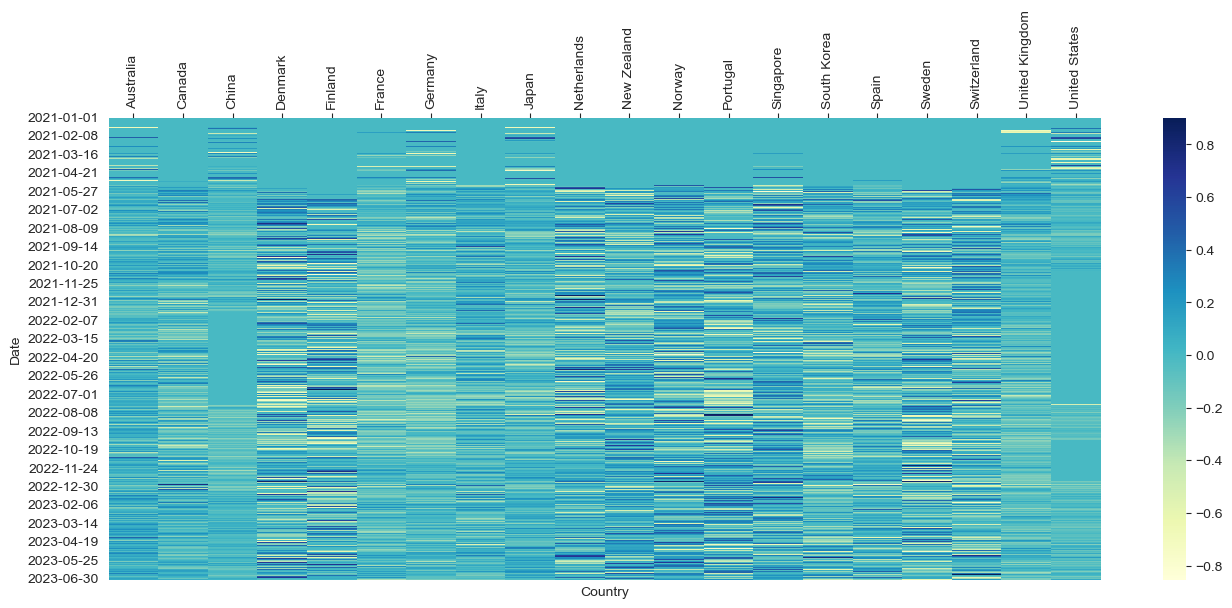

In [39]:
# 展示数据的Heatmap图, 颜色越深代表情感分数越高, 也就是越值得投资
df_sentiment2 = df_sentiment_aver[['Date', 'Country', 'Average']]
df_sentiment2['Date'] = pd.to_datetime(df_sentiment2['Date'], utc=True).dt.date
df_sentiment2 = pd.pivot_table(df_sentiment2, index=["Date"],columns="Country",values="Average")
ax = sn.heatmap(df_sentiment2, cmap="YlGnBu")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(16, 6)
# 保存图片
plt.savefig('../Data/Images/Heatmap.png', dpi=600, bbox_inches='tight')

In [40]:
# 将Average_Polarity和Return赋给merged_data
merged_data = pd.merge(df_sentiment_aver, df_sentiment, on=['Date', 'Country'], how='outer')
df_return_melted = df_return.melt(id_vars='Date', var_name='Country', value_name='Return')
merged_data = pd.merge(merged_data, df_return_melted, on=['Date', 'Country'], how='outer')
column_order = ['Date', 'Country', 'LMD', 'HIV4', 'Vader', 'FinBert', 'Average', 'Return']
merged_data = merged_data[column_order]

merged_data

,Date,Country,LMD,HIV4,Vader,FinBert,Average,Return
0,2021-01-01,Australia,0.0,0.0,0.0,0.0,0.0,-0.336272
1,2021-01-01,Canada,0.0,0.0,0.0,0.0,0.0,0.001849
2,2021-01-01,China,0.0,0.0,0.0,0.0,0.0,0.008714
3,2021-01-01,Denmark,0.0,0.0,0.0,0.0,0.0,-0.001258
4,2021-01-01,Finland,0.0,0.0,0.0,0.0,0.0,-0.001164
...,...,...,...,...,...,...,...,...
13666,2023-06-26,Korea,NaN,NaN,NaN,NaN,NaN,0.010047
13667,2023-06-27,Korea,NaN,NaN,NaN,NaN,NaN,0.010047
13668,2023-06-28,Korea,NaN,NaN,NaN,NaN,NaN,0.462870
13669,2023-06-29,Korea,NaN,NaN,NaN,NaN,NaN,-0.107440


In [41]:
merged_data = merged_data.dropna(subset=['Return'])

## Correlation And Accuracy

In [42]:
correlations = merged_data.corr().unstack().sort_values(ascending=False) # Build correlation matrix
correlations = pd.DataFrame(correlations).reset_index() # Convert to dataframe
correlations.columns = ['Return', 'Method', 'Correlation with Returns'] # Label it
result = correlations.query("Return == 'Return' & Method != 'Return'") # Filter by variable
result = result.drop(['Return'], axis = 1)


/var/folders/80/7fqc_wn17xz3qh01msrt026h0000gn/T/ipykernel_10509/3990684459.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = merged_data.corr().unstack().sort_values(ascending=False) # Build correlation matrix


,Method,Correlation with Returns
25,HIV4,0.004535
27,Vader,0.001908
29,Average,-0.007896
31,LMD,-0.012713
33,FinBert,-0.014118


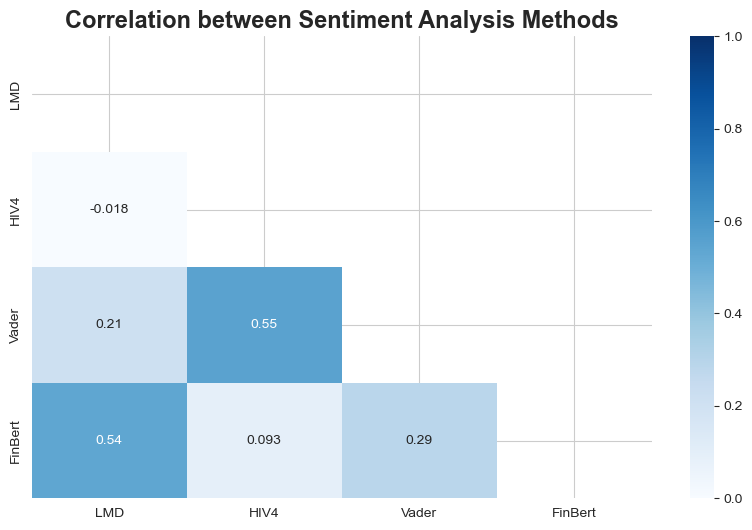

In [43]:
dfMethodCorrelation = pd.DataFrame(merged_data,columns=['LMD','HIV4','Vader', 'FinBert'])
corrMatrixPearson = dfMethodCorrelation.corr()
mask = np.triu(corrMatrixPearson)
sn.heatmap(corrMatrixPearson, annot=True, vmin=0, vmax=1, cmap="Blues", mask=mask)
plt.title("Correlation between Sentiment Analysis Methods", fontsize=17, fontweight="bold")
fig = plt.gcf()
fig.set_size_inches(10, 6)

In [44]:
strategies = ['LMD','HIV4','Vader', 'FinBert', 'Average']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1, dict_ret2, dict_ret3, dict_ret4, dict_ret5]

for x in range(0, len(strategies)):
    for i in range(0, len(all_dates)):
        sample_df = merged_data[merged_data['Date'] == all_dates[i]]
        sample_df = sample_df.dropna(subset=[strategies[x]])
        total_return = 0
        total_count = 0

        # 添加一个微小的随机扰动以避免并列
        # sample_df[strategies[x]] = sample_df[strategies[x]].apply(lambda x: x + np.random.uniform(-0.00001,0.00001))

        large_df = sample_df.nlargest(5, strategies[x])
        small_df = sample_df.nsmallest(5, strategies[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0:
            total_ret_long = total_ret_long / count_long

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = total_ret_long - total_ret_short
        dict_ret[x][all_dates[i]] = total_return


In [17]:
## To do: 检查
# 测试异常数据例如:2022/12/22, LMD收益为-24%
temp = merged_data[merged_data['Date'] == all_dates[-9]]
temp = temp.dropna(subset=[strategies[1]])
temp_large_df = temp.nlargest(5, strategies[0])
temp_small_df = temp.nsmallest(5, strategies[0])

temp_large_df

,Date,Country,LMD,HIV4,Vader,FinBert,Average,Return
57269,2022-12-22,Netherlands,0.083333,0.287231,0.360233,0.297397,0.257049,-0.418246
57271,2022-12-22,Norway,0.000000,0.000000,0.000000,0.000000,0.000000,-0.491399
57266,2022-12-22,Germany,-0.032327,0.490463,0.537936,0.011816,0.251972,-0.418225
57265,2022-12-22,France,-0.048919,0.425584,0.738215,-0.121585,0.248324,-0.483671
57263,2022-12-22,Denmark,-0.125000,0.542857,0.967800,-0.590588,0.198767,-0.503944


In [21]:
temp_small_df

KeyError: -8

In [54]:
new_portfolio_25 = pd.DataFrame(dict_ret).transpose()
new_portfolio_25 = new_portfolio_25.rename(columns={0: 'LMD', 1: 'HIV4', 2: 'Vader', 3: 'FinBert', 4: 'Average'})
new_portfolio_25.reset_index(inplace=True)
new_portfolio_25.rename(columns={'index': 'Date'}, inplace=True)

# new_portfolio_25.to_csv('../Data/25_percent_portfolio.csv')

In [55]:
new_portfolio_25

,Date,LMD,HIV4,Vader,FinBert,Average
0,2021-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
2,2021-01-03,0.000000,0.000000,0.000000,0.000000,0.000000
3,2021-01-04,0.000000,0.000000,0.000000,0.000000,0.000000
4,2021-01-05,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
906,2023-06-26,0.173630,0.171670,-0.001664,0.002843,0.173141
907,2023-06-27,-0.013358,0.017470,-0.036268,-0.081696,-0.090977
908,2023-06-28,-0.164984,-0.444099,-0.375874,-0.164349,-0.443039
909,2023-06-29,0.295333,0.629677,0.307631,-0.038380,0.562147


### IR of Long-Short Portfolio

In [56]:
strategies = ['LMD', 'HIV4', 'Vader', 'FinBert', 'Average']
IR_dict = {}

for strategy in strategies:
    returns = new_portfolio_25[strategy]
    average_return = np.mean(returns)
    std_return = np.std(returns)
    IR = average_return / std_return
    IR_dict[strategy] = IR

print(IR_dict)

{'LMD': -0.02834289678069613, 'HIV4': -0.02392908738901744, 'Vader': -0.0379950218482698, 'FinBert': -0.01656136022372285, 'Average': -0.03319316872688362}


In [48]:
new_portfolio_25

,Date,LMD,HIV4,Vader,FinBert,Average
0,2021-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
2,2021-01-03,0.000000,0.000000,0.000000,0.000000,0.000000
3,2021-01-04,0.000000,0.000000,0.000000,0.000000,0.000000
4,2021-01-05,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
906,2023-06-26,0.173630,0.171670,-0.001664,0.002843,0.173141
907,2023-06-27,-0.013358,0.017470,-0.036268,-0.081696,-0.090977
908,2023-06-28,-0.164984,-0.444099,-0.375874,-0.164349,-0.443039
909,2023-06-29,0.295333,0.629677,0.307631,-0.038380,0.562147


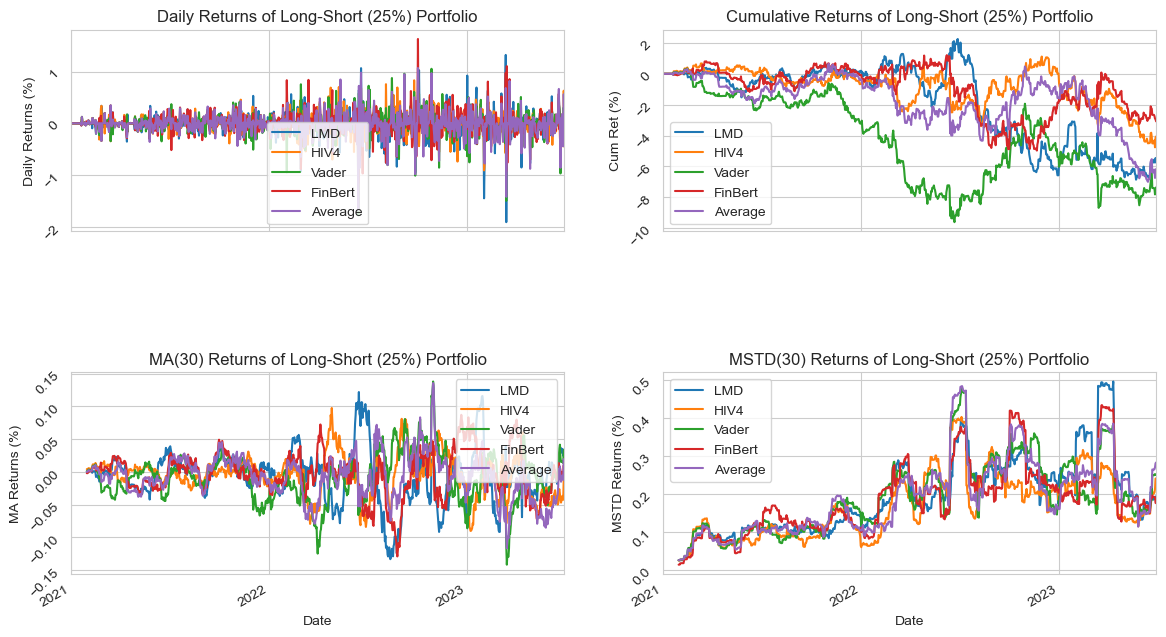

In [52]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.7)
new_portfolio_25 = new_portfolio_25.set_index('Date')
new_portfolio_25.plot(ax=ax1, title='Daily Returns of Long-Short (25%) Portfolio', xlabel='Date', ylabel='Daily Returns (%)', grid=True)
new_portfolio_25.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (25%) Portfolio', xlabel='Date', ylabel='Cum Ret (%)', grid=True)
new_portfolio_25.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (25%) Portfolio', xlabel='Date', ylabel='MA Returns (%)', grid=True)
new_portfolio_25.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (25%) Portfolio', xlabel='Date', ylabel='MSTD Returns (%)', grid=True)

# 创建日期范围
date_range = pd.date_range(start='2021-01-01', end='2023-06-30')

# 创建标签（选择每年的1月1日）
labels = date_range[date_range.is_year_start]

# 设置刻度和标签
ax1.set_xticks(labels)
ax1.set_xticklabels(labels.year)
ax2.set_xticks(labels)
ax2.set_xticklabels(labels.year)
ax3.set_xticks(labels)
ax3.set_xticklabels(labels.year)
ax4.set_xticks(labels)
ax4.set_xticklabels(labels.year)

ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)
ax3.tick_params(labelrotation=45)
ax4.tick_params(labelrotation=45)

# 防止标签重叠
plt.gcf().autofmt_xdate()
# 保存图片
plt.savefig('../Data/Images/25_percent_portfolio.png', dpi=900)
